In [1]:
from datasets import load_from_disk
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import re

/home1/am59710/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_from_disk('../../../eval_outputs/baseline_qwen/qwen3-4B-Instruct-2507_medmcqa_14000_5options')
ds

Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'prompt', 'correct_option', 'idk_option', 'model_response', 'model_answer'],
    num_rows: 14000
})

In [3]:
df = ds.to_pandas()

In [4]:
# df['correct'] = df.apply(lambda row: 'IDK' if row['model_answer'] == row['idk_option'] else str(row['model_answer'] == row['correct_option']), axis=1)
df["evaluated_answer"] = df["model_response"].str.extract(r"<answer>([A-Ea-e])<\/answer>")[0].str.upper()


df['correct'] = df.apply(lambda row: str(row['model_answer'] == row['correct_option']), axis=1)
df['regex_correct'] = df.apply(lambda row: str(row['evaluated_answer'] == row['correct_option']), axis=1)


In [5]:
df.columns

Index(['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type',
       'exp', 'subject_name', 'topic_name', 'prompt', 'correct_option',
       'idk_option', 'model_response', 'model_answer', 'evaluated_answer',
       'correct', 'regex_correct'],
      dtype='object')

Ground truth:
correct_option
A       4061
B       3705
C       3253
D       2981
E          0
None       0
Name: count, dtype: int64
Total: 14000

Model answers:
evaluated_answer
A       3633
B       3393
C       3011
D       2532
E       1019
None     412
Name: count, dtype: int64
Total 14000

Model's correct answers:
A       2752
B       2466
C       2093
D       1843
E          0
None       0
dtype: int64

Model's incorrect answers:
evaluated_answer
A        881
B        927
C        918
D        689
E       1019
None     412
dtype: int64



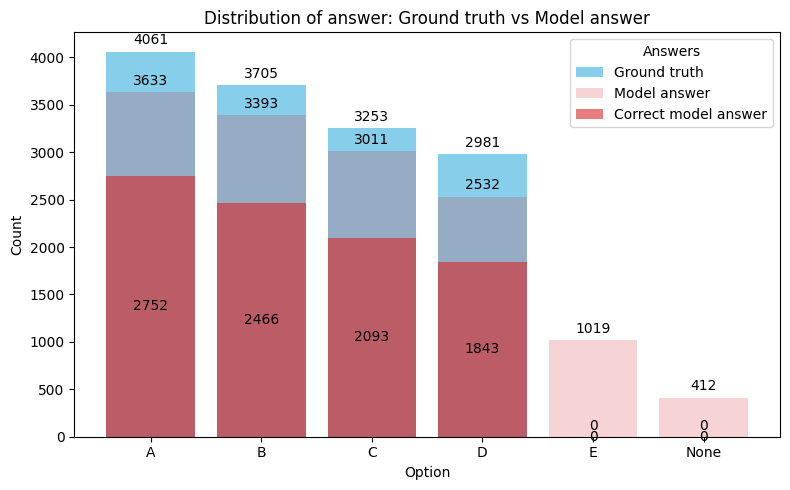

In [6]:
order = ['A','B','C','D', 'E', 'None']
plt.figure(figsize=(8,5))


truth_norm = df['correct_option'].fillna('None')
pred_norm = df['evaluated_answer'].fillna('None')

counts_truth = truth_norm.value_counts().reindex(order, fill_value=0)
categories = counts_truth.index.sort_values()
print("Ground truth:", counts_truth, sep = "\n")
print("Total:", sum(counts_truth))
print()
bar_truth = plt.bar(categories, counts_truth, color='skyblue',  alpha=1.0, label='Ground truth')
plt.bar_label(bar_truth, labels=[f"{v:d}" for v in counts_truth.values], padding=3) 


counts_pred = pred_norm.value_counts().reindex(order, fill_value=0)
categories = counts_pred.sort_index().index
print("Model answers:", counts_pred, sep = "\n")
print("Total", sum(counts_pred))
print()
bar_pred = plt.bar(categories, counts_pred, color='tab:red',alpha=0.2, label='Model answer')
plt.bar_label(bar_pred, labels=[f"{v:d}" for v in counts_pred.values], padding=3)


match_counts = pd.Series({opt: ((pred_norm == opt) & (truth_norm == opt)).sum() for opt in order})
mismatch_counts = (counts_pred - match_counts).clip(lower=0)
print("Model's correct answers:", match_counts, sep = "\n")
print()
print("Model's incorrect answers:", mismatch_counts, sep = "\n")
print()

bar_pred = plt.bar(categories, match_counts.values, color='tab:red', alpha=0.6, label='Correct model answer')

plt.bar_label(bar_pred, labels=[f"{int(v)}" for v in match_counts.values], label_type='center')



plt.xlabel('Option')
plt.ylabel('Count')
plt.title('Distribution of answer: Ground truth vs Model answer')
plt.legend(title='Answers')
plt.tight_layout()
plt.show()

In [7]:
sum(match_counts)

9154

In [8]:
sum(mismatch_counts)

4846

In [9]:
pattern = r"^<reasoning>.*?</reasoning>\s*<answer>.*</answer>$"
matches = [re.match(pattern, response, re.DOTALL) for response in df['model_response']]
format_reward = [1.0 if match else -1.0 for match in matches]

In [10]:
sum(format_reward)

12922.0

In [11]:
answers = df['evaluated_answer']
correct_option = df['correct_option']
idk_option = 'E'
accuracy_reward = []

for (ans, correct_ans) in zip(answers, correct_option):
    if ans == correct_ans:
        accuracy_reward.append(1)
    elif ans == idk_option:
        accuracy_reward.append(0)
    else:
        accuracy_reward.append(-1)

In [12]:
sum(accuracy_reward)

5327

In [13]:
total_rewards = sum(format_reward) + sum(accuracy_reward)
total_rewards

18249.0